# Word2Vec 연습

PTB 데이터셋을 이용하여 word2vec(skip-gram) 알고리즘을 구현해보는 연습

In [1]:
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda')

다음 PTB 데이터셋은 [여기](https://github.com/tomsercu/lstm)에서 다운로드

In [2]:
train_words = open('.\data\ptb.train.txt').read().replace('\n','<eos>').strip().split()

In [3]:
train_words[929580:]

['has',
 'been',
 'less',
 'prominent',
 'according',
 'to',
 'mr.',
 '<unk>',
 '<eos>']

In [4]:
len(train_words)

929589

In [5]:
word_to_id = {}
id_to_word = {}

In [6]:
for word in train_words:
    if word not in word_to_id:
        tmp_id = len(word_to_id)
        word_to_id[word]= tmp_id
        id_to_word[tmp_id]=word

In [7]:
len(word_to_id)

10000

In [8]:
vocab = set(word_to_id.keys())

In [9]:
len(vocab)

10000

In [10]:
HIDDEN_UNIT = 100
WINDOW_SIZE = 3

In [11]:
n_gram = []
for i in range(WINDOW_SIZE, len(train_words)-WINDOW_SIZE):
    data = [train_words[i], [train_words[i-j-1] for j in range(WINDOW_SIZE)]+
                             [train_words[i+j+1] for j in range(WINDOW_SIZE) ]]
    n_gram.append(data)

In [12]:
n_gram[0]

['calloway', ['berlitz', 'banknote', 'aer', 'centrust', 'cluett', 'fromstein']]

In [54]:
W, V = torch.randn((len(word_to_id),HIDDEN_UNIT)),torch.randn(HIDDEN_UNIT,len(word_to_id))

In [30]:
word = 'energy'
word_to_id[word]

454

In [61]:
h = W[word_to_id[word]].view(1,-1)
h.size()

torch.Size([1, 100])

In [63]:
torch.mm(h,V).size()

torch.Size([1, 10000])

In [13]:
class Word2vec(nn.Module):
    """
        데이터를 받으면 
    """
    
    def __init__(self,data=n_gram, vocab=vocab, window_size=WINDOW_SIZE,
                 word_to_id=word_to_id, id_to_word=id_to_word, hidden_unit=HIDDEN_UNIT):
        super(Word2vec, self).__init__()

        self.data = data
        self.vocab = vocab
        self.word_to_id = word_to_id
        self.id_to_word = id_to_word
        self.size = len(vocab)
        self.hidden = hidden_unit
        self.W1 = torch.nn.Linear(len(self.word_to_id),self.hidden, bias=False)
        self.W2 = torch.nn.Linear(self.hidden,len(self.word_to_id), bias=False)


        self.window_size = WINDOW_SIZE
        self.softmax = []
        for i in range(2* self.window_size):
            self.softmax.append(nn.LogSoftmax())
        
    def forward(self, x):
        y = torch.zeros((2* self.window_size, self.size))
        
        if type(x) == str:
            x = self.word_to_id[x]
            
        z = torch.zeros((1,len(self.vocab)))
        z[0,x] = 1
            
        for i in range(self.window_size):
            y[i] = self.softmax[i](self.W2(self.W1(z)))
            y[self.window_size+i] = self.softmax[self.window_size+i](self.W2(self.W1(z)))
        return y


In [14]:
word2vec = Word2vec()

In [17]:
word2vec.cuda(device)

Word2vec(
  (W1): Linear(in_features=10000, out_features=100, bias=False)
  (W2): Linear(in_features=100, out_features=10000, bias=False)
)

In [143]:
word2vec('next')

G:\Anaconda3\envs\PyTorch_ev\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
G:\Anaconda3\envs\PyTorch_ev\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-9.1663, -9.1202, -9.2288,  ..., -9.1777, -9.2252, -9.2213],
        [-9.1663, -9.1202, -9.2288,  ..., -9.1777, -9.2252, -9.2213],
        [-9.1663, -9.1202, -9.2288,  ..., -9.1777, -9.2252, -9.2213],
        [-9.1663, -9.1202, -9.2288,  ..., -9.1777, -9.2252, -9.2213],
        [-9.1663, -9.1202, -9.2288,  ..., -9.1777, -9.2252, -9.2213],
        [-9.1663, -9.1202, -9.2288,  ..., -9.1777, -9.2252, -9.2213]],
       grad_fn=<CopySlices>)

In [147]:
for i, param in enumerate(word2vec.named_parameters()):
    print(param)

('W1.weight', Parameter containing:
tensor([[-0.0006, -0.0045, -0.0035,  ..., -0.0043, -0.0015, -0.0034],
        [ 0.0002, -0.0041, -0.0044,  ...,  0.0096,  0.0016,  0.0029],
        [-0.0076,  0.0055,  0.0022,  ...,  0.0010, -0.0042,  0.0065],
        ...,
        [ 0.0019,  0.0001, -0.0017,  ...,  0.0044, -0.0033, -0.0054],
        [-0.0001,  0.0016,  0.0011,  ...,  0.0098,  0.0039,  0.0057],
        [-0.0041, -0.0096,  0.0030,  ..., -0.0050,  0.0002, -0.0075]],
       requires_grad=True))
('W1.bias', Parameter containing:
tensor([-0.0018, -0.0013,  0.0043,  0.0060,  0.0007,  0.0014, -0.0052, -0.0089,
        -0.0006,  0.0064, -0.0036,  0.0095, -0.0070,  0.0041,  0.0048, -0.0069,
         0.0098,  0.0023,  0.0064,  0.0074, -0.0019, -0.0042, -0.0019,  0.0096,
        -0.0034, -0.0035, -0.0003, -0.0013,  0.0009,  0.0089,  0.0085, -0.0061,
         0.0065, -0.0008, -0.0024, -0.0078,  0.0097, -0.0083, -0.0049,  0.0014,
         0.0043,  0.0070,  0.0014,  0.0009, -0.0013,  0.0006,  0.006

In [164]:
loss_f = nn.NLLLoss()
optim = torch.optim.SGD(word2vec.parameters(), lr=1e-4)

In [166]:
for i in range(len(n_gram)):
    y_pred = word2vec(n_gram[i][0])
    y = torch.tensor([word_to_id[w] for w in n_gram[i][1]], dtype=torch.long)
    
    optim.zero_grad()
    
    loss = loss_f(y_pred, y)
    
    loss.backward()
    optim.step()
    if i % 10 == 9 :
        print(i, loss)
    

G:\Anaconda3\envs\PyTorch_ev\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
G:\Anaconda3\envs\PyTorch_ev\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


9 tensor(9.2366, grad_fn=<NllLossBackward>)
19 tensor(9.2156, grad_fn=<NllLossBackward>)
29 tensor(9.2081, grad_fn=<NllLossBackward>)
39 tensor(9.2061, grad_fn=<NllLossBackward>)
49 tensor(9.2480, grad_fn=<NllLossBackward>)
59 tensor(9.2049, grad_fn=<NllLossBackward>)
69 tensor(9.1707, grad_fn=<NllLossBackward>)
79 tensor(9.1649, grad_fn=<NllLossBackward>)
89 tensor(9.1863, grad_fn=<NllLossBackward>)
99 tensor(9.2021, grad_fn=<NllLossBackward>)
109 tensor(9.2138, grad_fn=<NllLossBackward>)
119 tensor(9.1884, grad_fn=<NllLossBackward>)
129 tensor(9.1785, grad_fn=<NllLossBackward>)
139 tensor(9.1976, grad_fn=<NllLossBackward>)
149 tensor(9.2229, grad_fn=<NllLossBackward>)
159 tensor(9.2137, grad_fn=<NllLossBackward>)
169 tensor(9.2041, grad_fn=<NllLossBackward>)
179 tensor(9.2244, grad_fn=<NllLossBackward>)
189 tensor(9.2095, grad_fn=<NllLossBackward>)
199 tensor(9.2138, grad_fn=<NllLossBackward>)
209 tensor(9.2312, grad_fn=<NllLossBackward>)
219 tensor(9.2466, grad_fn=<NllLossBackward>)

KeyboardInterrupt: 

In [32]:
class Word2vec_cbow(nn.Module):
    """
        데이터를 받으면 
    """
    
    def __init__(self,data=n_gram, vocab=vocab, window_size=WINDOW_SIZE,
                 word_to_id=word_to_id, id_to_word=id_to_word, hidden_unit=HIDDEN_UNIT):
        super(Word2vec_cbow, self).__init__()

        self.data = data
        self.vocab = vocab
        self.word_to_id = word_to_id
        self.id_to_word = id_to_word
        self.size = len(vocab)
        self.hidden = hidden_unit
        self.W1 = torch.nn.Linear(len(self.word_to_id),self.hidden)
        self.W2 = torch.nn.Linear(self.hidden,len(self.word_to_id))


        self.window_size = WINDOW_SIZE
        self.softmax = nn.LogSoftmax()

        
    def forward(self, x):
        z = torch.zeros(2*self.window_size, self.size)
        for i in range(2*self.window_size):
            z[i, x[i]] += 1
        h = self.W1(z).sum(dim=0)
        return self.softmax(self.W2(h))
        

            
            
            

In [33]:
cbow = Word2vec_cbow()

In [17]:
x = [word_to_id[w] for w in n_gram[0][1]]
x

[2, 1, 0, 4, 5, 6]

In [25]:
y_pred = cbow(x)
y_pred

G:\Anaconda3\envs\PyTorch_ev\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([-9.2589, -9.2380, -9.1977,  ..., -9.1968, -9.3090, -9.2293],
       grad_fn=<LogSoftmaxBackward>)

In [19]:
cbow(x).size()

G:\Anaconda3\envs\PyTorch_ev\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([10000])

In [24]:
y = torch.tensor([word_to_id[n_gram[0][0]]], dtype=torch.long)
y

tensor([3])

In [27]:
loss_f(y_pred.view(1,-1), y)

tensor(9.2076, grad_fn=<NllLossBackward>)

In [199]:
torch.tensor(word_to_id[n_gram[1100][0]], dtype=torch.long).view(1)

tensor([342])

In [34]:
loss_f = nn.NLLLoss()
optim = torch.optim.SGD(cbow.parameters(), lr=1e-4)

In [35]:
losses=0
results = []
for i in range(len(n_gram)):
    
    z = torch.tensor([word_to_id[w] for w in n_gram[i][1]], dtype=torch.long)
    y_pred = cbow(z).view(1,-1)
    y = torch.tensor(word_to_id[n_gram[i][0]], dtype=torch.long).view(1)
    
    optim.zero_grad()
    
    loss = loss_f(y_pred, y)
    
    loss.backward()
    losses += loss
    optim.step()
    if i % 1000 == 999 :
        print(i+1, losses/1000)
        results.append(losses/1000)
        losses=0
        
    

G:\Anaconda3\envs\PyTorch_ev\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1000 tensor(9.2041, grad_fn=<DivBackward0>)
2000 tensor(9.1792, grad_fn=<DivBackward0>)
3000 tensor(9.1729, grad_fn=<DivBackward0>)
4000 tensor(9.1554, grad_fn=<DivBackward0>)
5000 tensor(9.1491, grad_fn=<DivBackward0>)
6000 tensor(9.1150, grad_fn=<DivBackward0>)
7000 tensor(9.1077, grad_fn=<DivBackward0>)
8000 tensor(9.0939, grad_fn=<DivBackward0>)
9000 tensor(9.0479, grad_fn=<DivBackward0>)
10000 tensor(9.0121, grad_fn=<DivBackward0>)
11000 tensor(9.0091, grad_fn=<DivBackward0>)
12000 tensor(8.9370, grad_fn=<DivBackward0>)
13000 tensor(8.9541, grad_fn=<DivBackward0>)
14000 tensor(8.9186, grad_fn=<DivBackward0>)
15000 tensor(8.8790, grad_fn=<DivBackward0>)
16000 tensor(8.8631, grad_fn=<DivBackward0>)
17000 tensor(8.8526, grad_fn=<DivBackward0>)
18000 tensor(8.7179, grad_fn=<DivBackward0>)
19000 tensor(8.6109, grad_fn=<DivBackward0>)
20000 tensor(8.5900, grad_fn=<DivBackward0>)
21000 tensor(8.6058, grad_fn=<DivBackward0>)
22000 tensor(8.4163, grad_fn=<DivBackward0>)
23000 tensor(8.3715

359000 tensor(6.5786, grad_fn=<DivBackward0>)
360000 tensor(6.5413, grad_fn=<DivBackward0>)
361000 tensor(6.3726, grad_fn=<DivBackward0>)
362000 tensor(6.4592, grad_fn=<DivBackward0>)
363000 tensor(6.4728, grad_fn=<DivBackward0>)
364000 tensor(6.5916, grad_fn=<DivBackward0>)
365000 tensor(6.6369, grad_fn=<DivBackward0>)
366000 tensor(6.6985, grad_fn=<DivBackward0>)
367000 tensor(6.4623, grad_fn=<DivBackward0>)
368000 tensor(6.5804, grad_fn=<DivBackward0>)
369000 tensor(6.6657, grad_fn=<DivBackward0>)
370000 tensor(6.4315, grad_fn=<DivBackward0>)
371000 tensor(6.7554, grad_fn=<DivBackward0>)
372000 tensor(6.8661, grad_fn=<DivBackward0>)
373000 tensor(6.8029, grad_fn=<DivBackward0>)
374000 tensor(6.8621, grad_fn=<DivBackward0>)
375000 tensor(6.4154, grad_fn=<DivBackward0>)
376000 tensor(6.6608, grad_fn=<DivBackward0>)
377000 tensor(6.7679, grad_fn=<DivBackward0>)
378000 tensor(6.8605, grad_fn=<DivBackward0>)
379000 tensor(6.4828, grad_fn=<DivBackward0>)
380000 tensor(6.5901, grad_fn=<Div

KeyboardInterrupt: 

In [36]:
torch.save(cbow.state_dict(), 'cbow.pt')

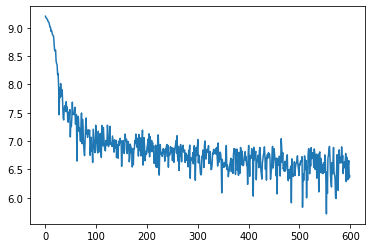

In [37]:
plt.plot(results)

In [39]:
for i, param in enumerate(cbow.named_parameters()):
    print(param)

('W1.weight', Parameter containing:
tensor([[-0.0058, -0.0011,  0.0053,  ..., -0.0056,  0.0037,  0.0068],
        [-0.0063, -0.0057, -0.0035,  ...,  0.0025, -0.0087,  0.0022],
        [-0.0100, -0.0069,  0.0035,  ...,  0.0026, -0.0042, -0.0056],
        ...,
        [ 0.0027, -0.0055, -0.0067,  ..., -0.0011,  0.0012,  0.0066],
        [-0.0009, -0.0034, -0.0001,  ...,  0.0013, -0.0083,  0.0041],
        [ 0.0016, -0.0036, -0.0064,  ...,  0.0075,  0.0026,  0.0089]],
       requires_grad=True))
('W1.bias', Parameter containing:
tensor([-0.6288,  0.1632,  0.2319, -0.2753,  0.1832, -0.3666, -0.3604,  0.0961,
         0.3225,  0.3186, -0.1721,  0.2441, -0.1717, -0.0215, -0.1328,  0.2377,
        -0.4023, -0.1777, -0.0311, -0.2939,  0.5834,  0.2970, -0.1646, -0.1901,
         0.0737,  0.1789,  0.3678, -0.0649, -0.0212,  0.4274,  0.2162, -0.5541,
        -0.0227, -0.0289, -0.0528,  0.1646,  0.0302,  0.1544,  0.0020, -0.3992,
        -0.0839, -0.0307, -0.1826,  0.4011,  0.2746,  0.1748, -0.178